In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
from collections import Counter
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import torch
from transformers import pipeline
from tqdm.auto import tqdm
import warnings
import joblib
import os
warnings.filterwarnings('ignore')

In [4]:
# Загрузка данных
df = pd.read_json('Sarcasm_Headlines_Dataset_v2.json', lines=True)
df.shape

(28619, 3)

In [5]:
df.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28619 entries, 0 to 28618
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   is_sarcastic  28619 non-null  int64 
 1   headline      28619 non-null  object
 2   article_link  28619 non-null  object
dtypes: int64(1), object(2)
memory usage: 670.9+ KB


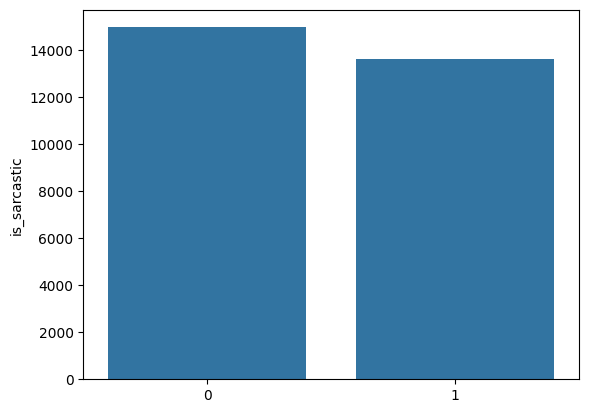

In [7]:
sns.barplot(df['is_sarcastic'].value_counts());

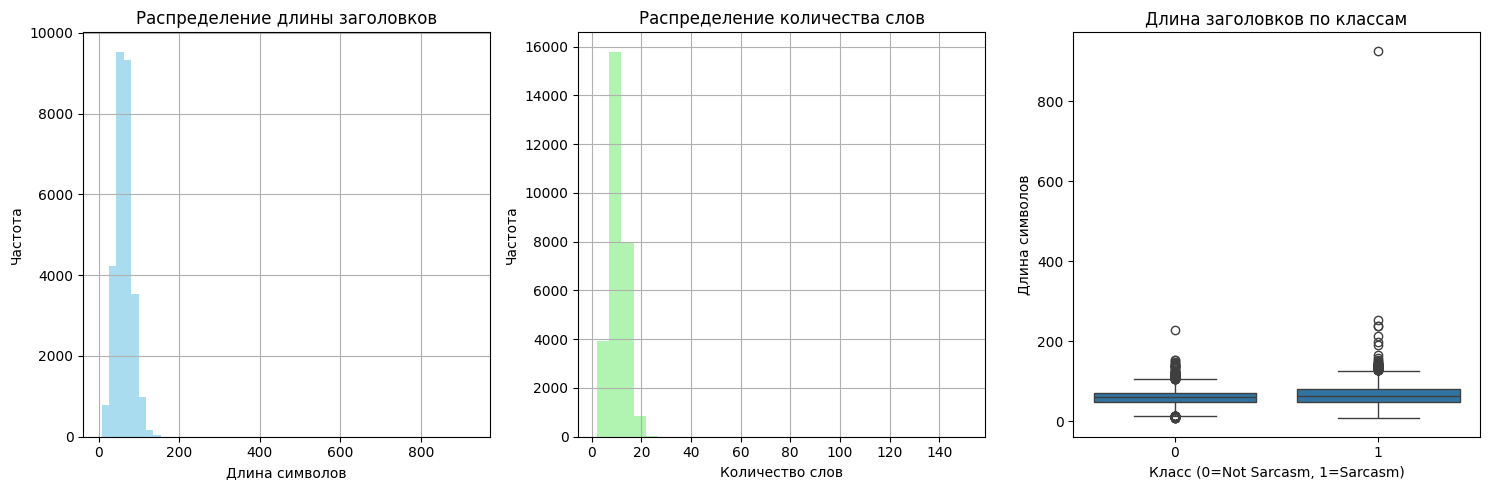

                count       mean        std  min   25%   50%   75%    max
is_sarcastic                                                             
0             14985.0  59.558625  17.318876  7.0  48.0  61.0  71.0  228.0
1             13634.0  65.331011  23.551257  8.0  49.0  64.0  80.0  926.0


In [8]:
# Анализ длины заголовков
df['headline_length'] = df['headline'].apply(len)
df['word_count'] = df['headline'].apply(lambda x: len(x.split()))

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
df['headline_length'].hist(bins=50, alpha=0.7, color='skyblue')
plt.title('Распределение длины заголовков')
plt.xlabel('Длина символов')
plt.ylabel('Частота')

plt.subplot(1, 3, 2)
df['word_count'].hist(bins=30, alpha=0.7, color='lightgreen')
plt.title('Распределение количества слов')
plt.xlabel('Количество слов')
plt.ylabel('Частота')

plt.subplot(1, 3, 3)
sns.boxplot(x='is_sarcastic', y='headline_length', data=df)
plt.title('Длина заголовков по классам')
plt.xlabel('Класс (0=Not Sarcasm, 1=Sarcasm)')
plt.ylabel('Длина символов')

plt.tight_layout()
plt.show()

print(df.groupby('is_sarcastic')['headline_length'].describe())

In [9]:
# Предобработка текста
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

In [10]:
# Загрузка необходимых ресурсов NLTK
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

True

In [11]:
def preprocess_text(text):
    """Функция для предобработки текста"""
    # Приведение к нижнему регистру
    text = text.lower()

    # Удаление пунктуации и цифр
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)

    # Токенизация
    tokens = word_tokenize(text)

    # Удаление стоп-слов и лемматизация
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()

    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words and len(token) > 2]

    return ' '.join(tokens)

In [12]:
# Применяем предобработку
df['cleaned_headline'] = df['headline'].apply(preprocess_text)

In [13]:
# Разделение данных
X = df['cleaned_headline']
y = df['is_sarcastic']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_train.shape[0]
X_test.shape[0]

5724

In [14]:
# TF-IDF векторизация
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.8
)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

X_train_tfidf.shape

(22895, 5000)

In [15]:
# Словарь для хранения результатов
results = {}

In [16]:
# Функция для оценки классических моделей
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    start_time = time.time()

    # Обучение модели
    model.fit(X_train, y_train)
    train_time = time.time() - start_time

    # Предсказания
    start_pred_time = time.time()
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    pred_time = time.time() - start_pred_time

    # Метрики
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    # Сохранение результатов
    results[model_name] = {
        'model': model,
        'accuracy': accuracy,
        'f1_score': f1,
        'roc_auc': roc_auc,
        'train_time': train_time,
        'prediction_time': pred_time,
        'predictions': y_pred,
        'probabilities': y_pred_proba,
        'type': 'classical'
    }

    print(f"\n{model_name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")
    print(f"Время обучения: {train_time:.2f} сек")
    print(f"Время предсказания: {pred_time:.4f} сек")

    return results[model_name]


In [17]:
# Обучение классических моделей
# Наивный Байес
nb_model = MultinomialNB()
evaluate_model(nb_model, X_train_tfidf, X_test_tfidf, y_train, y_test, "Naive Bayes")

# Логистическая регрессия
lr_model = LogisticRegression(random_state=42, max_iter=1000)
evaluate_model(lr_model, X_train_tfidf, X_test_tfidf, y_train, y_test, "Logistic Regression")

# Случайный лес
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
evaluate_model(rf_model, X_train_tfidf, X_test_tfidf, y_train, y_test, "Random Forest")

# XGBoost
xgb_model = XGBClassifier(random_state=42, eval_metric='logloss')
evaluate_model(xgb_model, X_train_tfidf, X_test_tfidf, y_train, y_test, "XGBoost")


Naive Bayes:
Accuracy: 0.7830
F1-Score: 0.7655
ROC-AUC: 0.8687
Время обучения: 0.00 сек
Время предсказания: 0.0006 сек

Logistic Regression:
Accuracy: 0.7848
F1-Score: 0.7644
ROC-AUC: 0.8691
Время обучения: 0.05 сек
Время предсказания: 0.0003 сек

Random Forest:
Accuracy: 0.7514
F1-Score: 0.7288
ROC-AUC: 0.8343
Время обучения: 8.92 сек
Время предсказания: 1.5711 сек

XGBoost:
Accuracy: 0.7117
F1-Score: 0.6377
ROC-AUC: 0.7950
Время обучения: 1.11 сек
Время предсказания: 0.0061 сек


{'model': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric='logloss',
               feature_types=None, gamma=None, grow_policy=None,
               importance_type=None, interaction_constraints=None,
               learning_rate=None, max_bin=None, max_cat_threshold=None,
               max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
               max_leaves=None, min_child_weight=None, missing=nan,
               monotone_constraints=None, multi_strategy=None, n_estimators=None,
               n_jobs=None, num_parallel_tree=None, random_state=42, ...),
 'accuracy': 0.7117400419287212,
 'f1_score': 0.6376811594202898,
 'roc_auc': 0.7949599764781283,
 'train_time': 1.1050570011138916,
 'prediction_time': 0.006059169769287109,
 'predictions': array([0, 0, 0, ..., 0, 1, 

In [18]:
# Используем оригинальные тексты для трансформеров
X_train_original = df.loc[X_train.index, 'headline']
X_test_original = df.loc[X_test.index, 'headline']

In [19]:
# Трансформерная модель для анализа настроений
def evaluate_light_sentiment_model():
    """Оценка модели анализа настроений для обнаружения сарказма"""
    try:
        # Используем модель для анализа настроений
        model_name = "distilbert-base-uncased-finetuned-sst-2-english"
        print(f"Модель: {model_name}")
        
        # Создаем пайплайн для анализа настроений
        classifier = pipeline(
            "sentiment-analysis",
            model=model_name,
            device=-1,  
            batch_size=8
        )
        
        # Берем выборку для тестирования (100 примеров)
        sample_size = 100
        sample_texts = X_test_original[:sample_size].tolist()
        true_labels = y_test[:sample_size].tolist()
        
        predictions = []
        probabilities = []
        processing_details = []
        
        start_time = time.time()
        
        # Обрабатываем тексты с прогресс-баром
        for i, text in enumerate(tqdm(sample_texts, desc="Анализ текстов")):
            try:
                # Анализируем настроение текста
                result = classifier(text[:512])[0]
                
                # Извлекаем метку и оценку уверенности
                label = result['label']
                score = result['score']
                
                # ЭВРИСТИКА: считаем, что негативные тексты могут быть саркастичными
                # Модель возвращает 'NEGATIVE' или 'POSITIVE'
                if 'NEG' in label.upper():
                    pred = 1  # Сарказм
                    prob = score
                else:
                    pred = 0  # Не сарказм
                    prob = 1 - score
                
                predictions.append(pred)
                probabilities.append(prob)
                
                # Сохраняем детали для анализа
                processing_details.append({
                    'text': text[:50] + '...' if len(text) > 50 else text,
                    'true_label': true_labels[i],
                    'predicted_label': pred,
                    'sentiment_label': label,
                    'sentiment_score': score,
                    'sarcasm_probability': prob
                })
                
            except Exception as e:
                # В случае ошибки предсказываем "не сарказм"
                predictions.append(0)
                probabilities.append(0.5)
                processing_details.append({
                    'text': text[:50] + '...' if len(text) > 50 else text,
                    'true_label': true_labels[i],
                    'predicted_label': 0,
                    'sentiment_label': 'ERROR',
                    'sentiment_score': 0.5,
                    'sarcasm_probability': 0.5,
                    'error': str(e)
                })
        
        prediction_time = time.time() - start_time
        
        # Вычисляем метрики
        accuracy = accuracy_score(true_labels, predictions)
        f1 = f1_score(true_labels, predictions)
        roc_auc = roc_auc_score(true_labels, probabilities)
        
        # Сохраняем результаты
        results[model_name + "_sentiment"] = {
            'model': classifier,
            'accuracy': accuracy,
            'f1_score': f1,
            'roc_auc': roc_auc,
            'train_time': 0,
            'prediction_time': prediction_time,
            'predictions': predictions,
            'probabilities': probabilities,
            'processing_details': processing_details,
            'type': 'transformer_sentiment'
        }
        
        # Выводим результаты
        print(f"\n РЕЗУЛЬТАТЫ {model_name}:")
        print(f" Accuracy: {accuracy:.4f}")
        print(f" F1-Score: {f1:.4f}")
        print(f" ROC-AUC: {roc_auc:.4f}")
        print(f"  Время предсказания: {prediction_time:.2f} сек")
        
        # Детальный анализ нескольких примеров
        
        correct_examples = [d for d in processing_details if d['true_label'] == d['predicted_label']]
        incorrect_examples = [d for d in processing_details if d['true_label'] != d['predicted_label']]
        
        print(f"Правильно классифицировано: {len(correct_examples)}/{len(processing_details)}")
        print(f"Неправильно классифицировано: {len(incorrect_examples)}/{len(processing_details)}")
        
        # Показываем несколько примеров
        print(f"\nПРИМЕРЫ ПРЕДСКАЗАНИЙ:")
        for i in range(min(3, len(processing_details))):
            detail = processing_details[i]
            status = " ВЕРНО" if detail['true_label'] == detail['predicted_label'] else "ОШИБКА"
            true_class = "Сарказм" if detail['true_label'] == 1 else "Не сарказм"
            pred_class = "Сарказм" if detail['predicted_label'] == 1 else "Не сарказм"
            
            print(f"{status}")
            print(f"   Текст: {detail['text']}")
            print(f"   Истинный класс: {true_class}")
            print(f"   Предсказанный класс: {pred_class}")
            print(f"   Настроение: {detail['sentiment_label']} (уверенность: {detail['sentiment_score']:.3f})")
            print(f"   Вероятность сарказма: {detail['sarcasm_probability']:.3f}")
            print()
        
        return results[model_name + "_sentiment"]
        
    except Exception as e:
        print(f" Ошибка при оценке модели: {str(e)}")
        import traceback
        traceback.print_exc()
        return 

In [ ]:
# Запускаем оценку трансформерной модели
transformer_result = evaluate_light_sentiment_model()

Модель: distilbert-base-uncased-finetuned-sst-2-english


Device set to use cpu


Анализ текстов:   0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
# Создание DataFrame с результатами всех моделей
all_results = []
for model_name, result in results.items():
    all_results.append({
        'Model': model_name,
        'Type': result.get('type', 'classical'),
        'Accuracy': result['accuracy'],
        'F1-Score': result['f1_score'],
        'ROC-AUC': result['roc_auc'],
        'Training_Time': result['train_time'],
        'Prediction_Time': result['prediction_time']
    })

all_results_df = pd.DataFrame(all_results)
all_results_df = all_results_df.sort_values('F1-Score', ascending=False)

print("\nСравнение моделей (отсортировано по F1-Score):")
print(all_results_df.round(4))

In [ ]:
# Визуализация сравнения моделей
plt.figure(figsize=(15, 10))

In [ ]:
# Цвета для разных типов моделей
colors = []
for model_type in all_results_df['Type']:
    if 'transformer' in str(model_type):
        colors.append('orange')
    else:
        colors.append('blue')